In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from opxrd.wrapper import OpXRD

# ------------------------------------------------------------

bigtest_database = OpXRD.load_project_list(root_dirpath='/home/daniel/aimat/data/opXRD/test')
smoltest_databse = OpXRD.load_project_list(root_dirpath='/home/daniel/aimat/data/opXRD/test_smol')

- Loading databases from /home/daniel/aimat/data/opXRD/test
[2024-12-22 15:13:47]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/EMPA


100% (770 of 770) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000


[2024-12-22 15:13:48]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/EMPA
[2024-12-22 15:13:48]: Successfully extracted 770 patterns from 770/770 xrd files
[2024-12-22 15:13:48]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/LBNL/UiO_compounds


100% (1348 of 1348) |####################| Elapsed Time: 0:00:01 Time:  0:00:010000


[2024-12-22 15:13:49]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/LBNL/UiO_compounds
[2024-12-22 15:13:49]: Successfully extracted 1348 patterns from 1348/1348 xrd files
[2024-12-22 15:13:49]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/LBNL/MnSbO_annealing


100% (342 of 342) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000


[2024-12-22 15:13:50]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/LBNL/MnSbO_annealing
[2024-12-22 15:13:50]: Successfully extracted 342 patterns from 342/342 xrd files
[2024-12-22 15:13:50]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/LBNL/perovskites


100% (1047 of 1047) |####################| Elapsed Time: 0:00:00 Time:  0:00:000000


[2024-12-22 15:13:50]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/LBNL/perovskites
[2024-12-22 15:13:50]: Successfully extracted 1047 patterns from 1047/1047 xrd files
[2024-12-22 15:13:50]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/USC


100% (338 of 338) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000


[2024-12-22 15:13:51]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/USC
[2024-12-22 15:13:51]: Successfully extracted 338 patterns from 338/338 xrd files
[2024-12-22 15:13:51]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/INT


100% (1127 of 1127) |####################| Elapsed Time: 0:00:01 Time:  0:00:010000


[2024-12-22 15:13:52]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/INT
[2024-12-22 15:13:52]: Successfully extracted 1127 patterns from 1127/1127 xrd files
[2024-12-22 15:13:52]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/HKUST/in_house


100% (21 of 21) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


[2024-12-22 15:13:53]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/HKUST/in_house
[2024-12-22 15:13:53]: Successfully extracted 21 patterns from 21/21 xrd files
[2024-12-22 15:13:53]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/HKUST/accumulated


100% (499 of 499) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000


[2024-12-22 15:13:54]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/HKUST/accumulated
[2024-12-22 15:13:54]: Successfully extracted 499 patterns from 499/499 xrd files
[2024-12-22 15:13:54]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/CNRS


100% (210 of 210) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000


[2024-12-22 15:13:55]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/CNRS
[2024-12-22 15:13:55]: Successfully extracted 210 patterns from 210/210 xrd files
[2024-12-22 15:13:55]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/IKFT


100% (64 of 64) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


[2024-12-22 15:13:55]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/IKFT
[2024-12-22 15:13:55]: Successfully extracted 64 patterns from 64/64 xrd files
- Loading databases from /home/daniel/aimat/data/opXRD/test_smol
[2024-12-22 15:13:55]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test_smol/USC


100% (174 of 174) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000


[2024-12-22 15:13:55]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test_smol/USC
[2024-12-22 15:13:55]: Successfully extracted 174 patterns from 174/174 xrd files
[2024-12-22 15:13:55]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test_smol/CNRS


100% (27 of 27) |########################| Elapsed Time: 0:00:00 Time:  0:00:000000


[2024-12-22 15:13:56]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test_smol/CNRS
[2024-12-22 15:13:56]: Successfully extracted 27 patterns from 27/27 xrd files


In [28]:
from opxrd.analysis import DatabaseAnalyser

analyser = DatabaseAnalyser(databases=bigtest_database, output_dirpath='/tmp/opxrd_analysis')
smol_analyser = DatabaseAnalyser(databases=smoltest_databse, output_dirpath='/tmp/opxrd_analysis')

---> Fourier transform of gaussians of the form $I(x) = e^{-0.5(x-b)^2/c}$

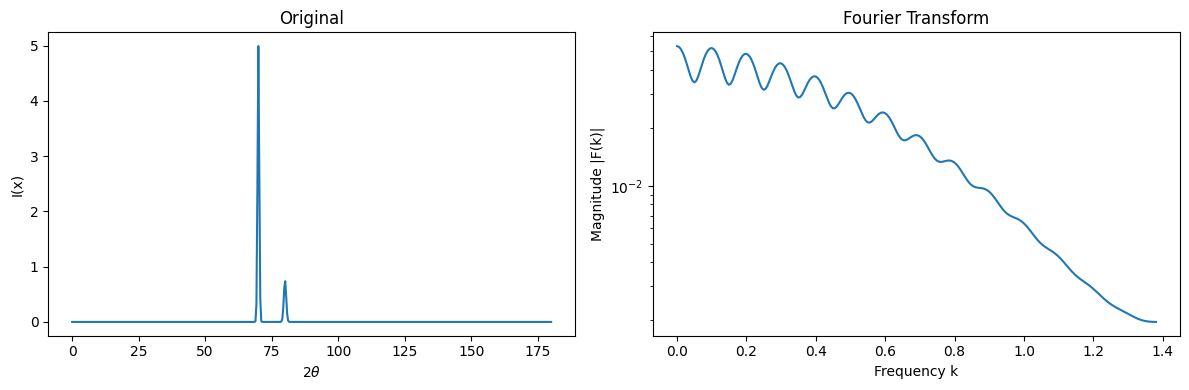

---> Fourier transform of summed USC patterns

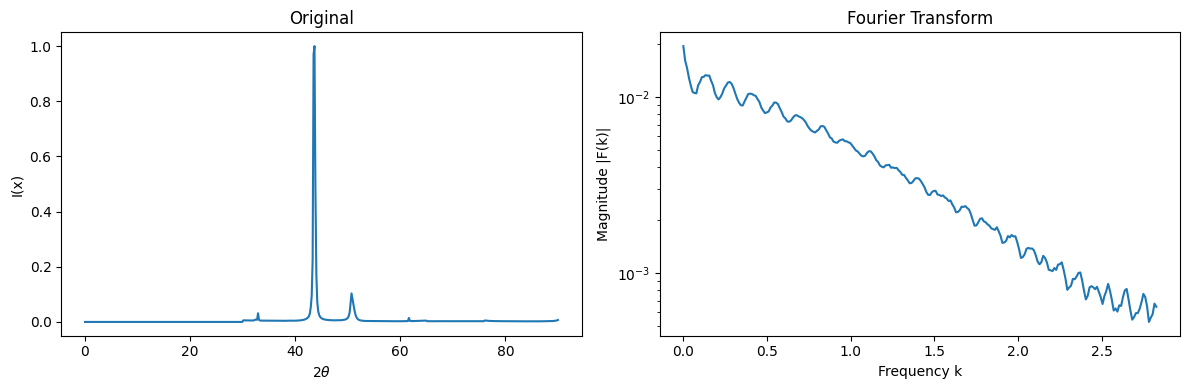

In [29]:
analyser.plot_reference_fourier(b1=70, b2=80, b3 = 60, add_noise=False)
smol_analyser.plot_opxrd_fourier(combine_plots=False, filter_dbs='USC')

---> Fourier transform of summed up opXRD patterns

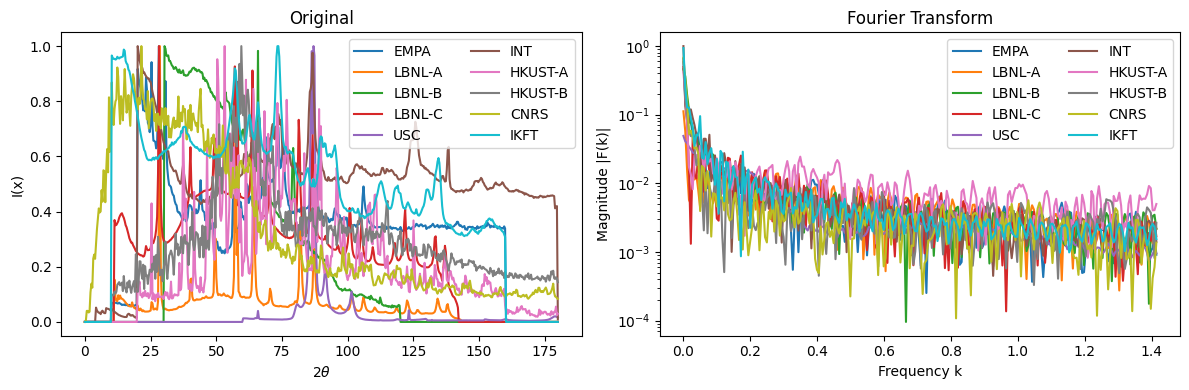

---> Fourier transform of summed EMPA patterns

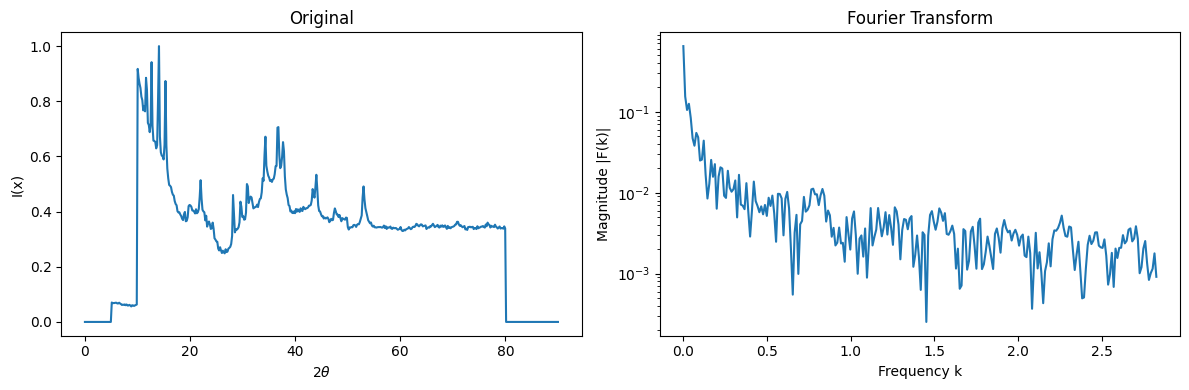

---> Fourier transform of summed LBNL-A patterns

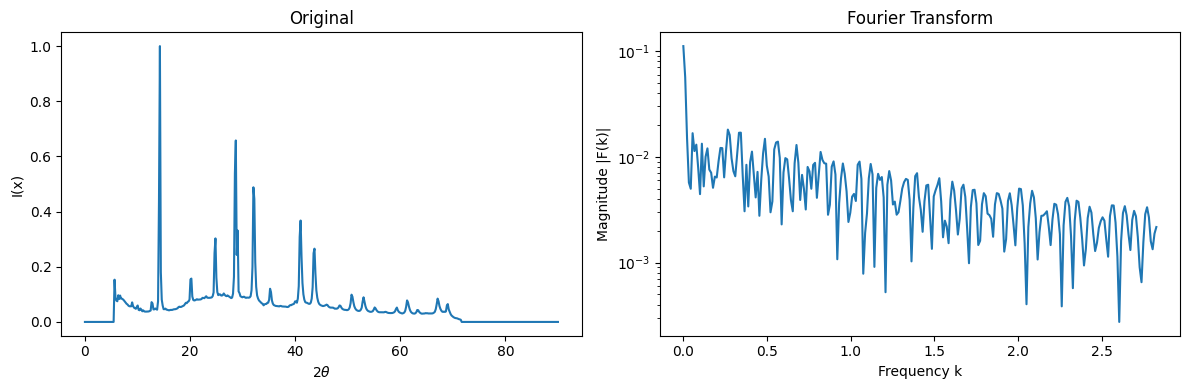

---> Fourier transform of summed LBNL-B patterns

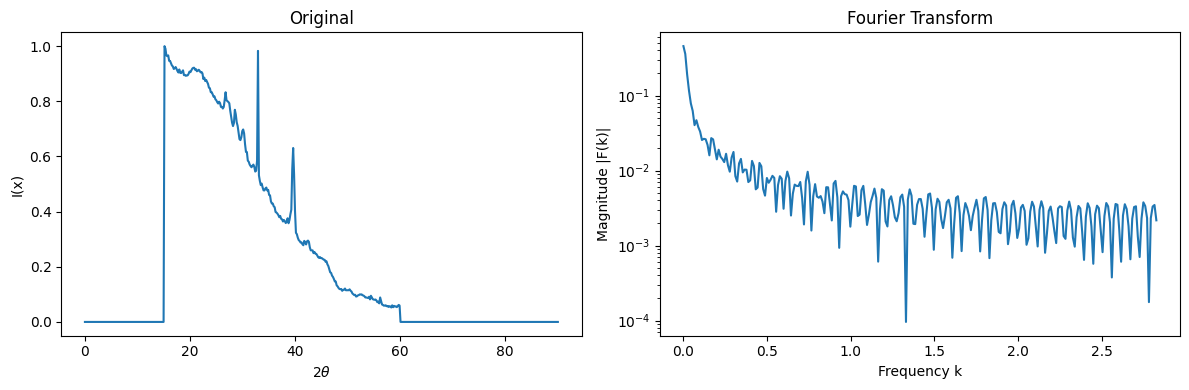

---> Fourier transform of summed LBNL-C patterns

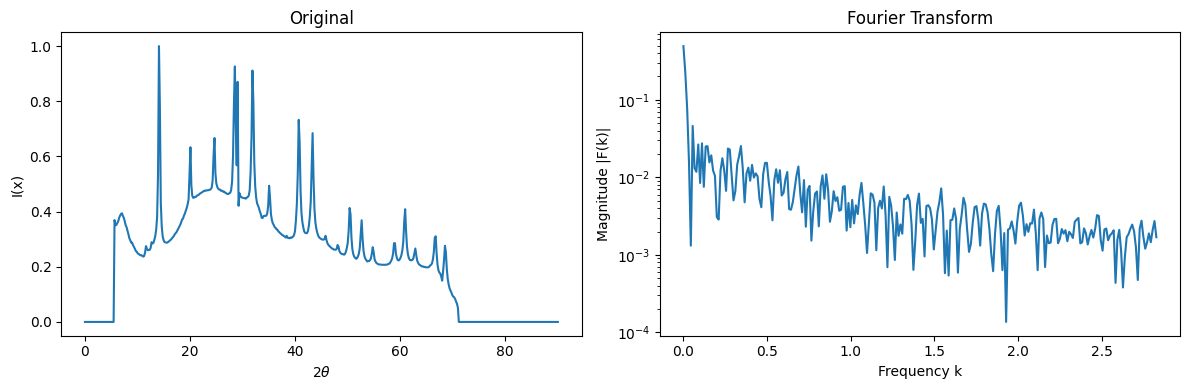

---> Fourier transform of summed USC patterns

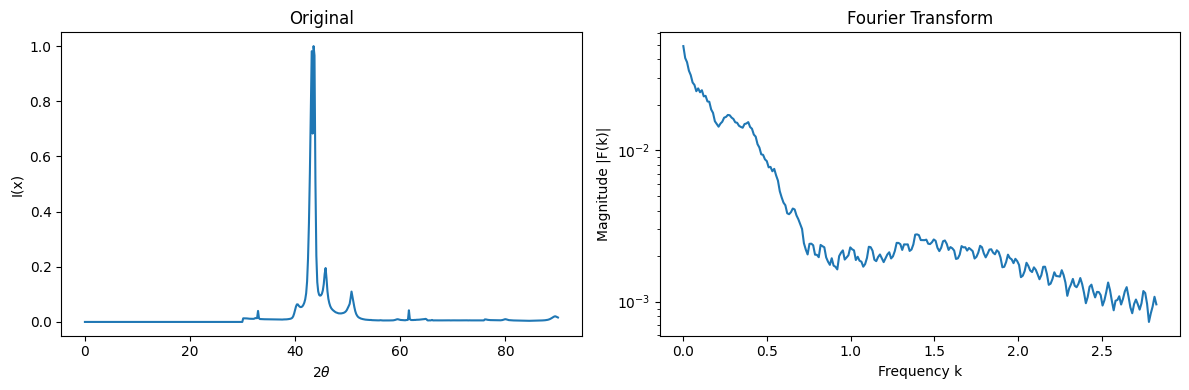

---> Fourier transform of summed INT patterns

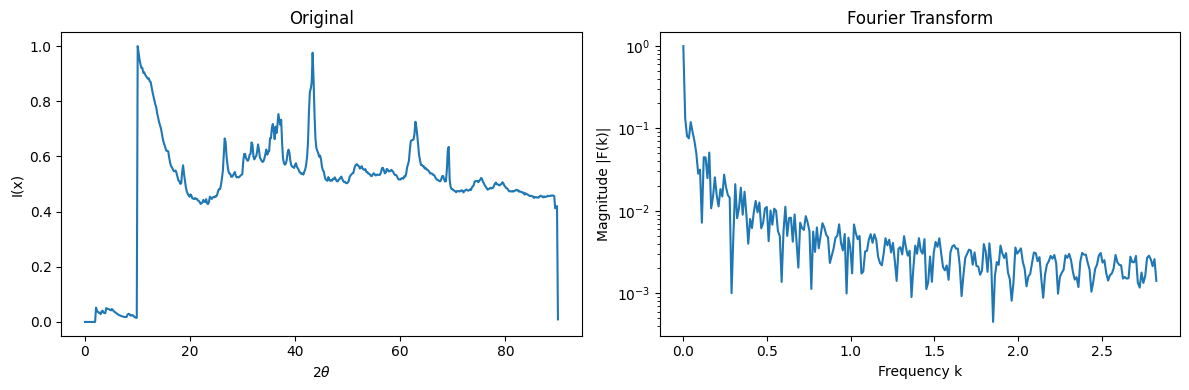

---> Fourier transform of summed HKUST-A patterns

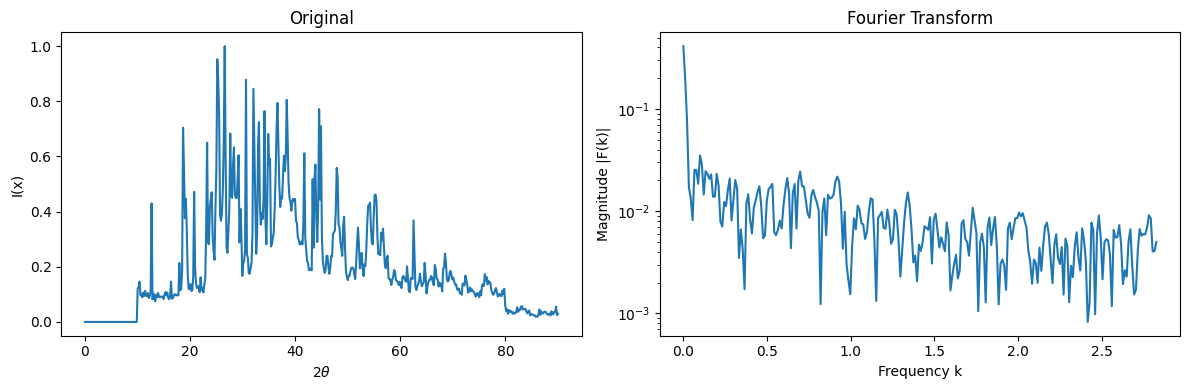

---> Fourier transform of summed HKUST-B patterns

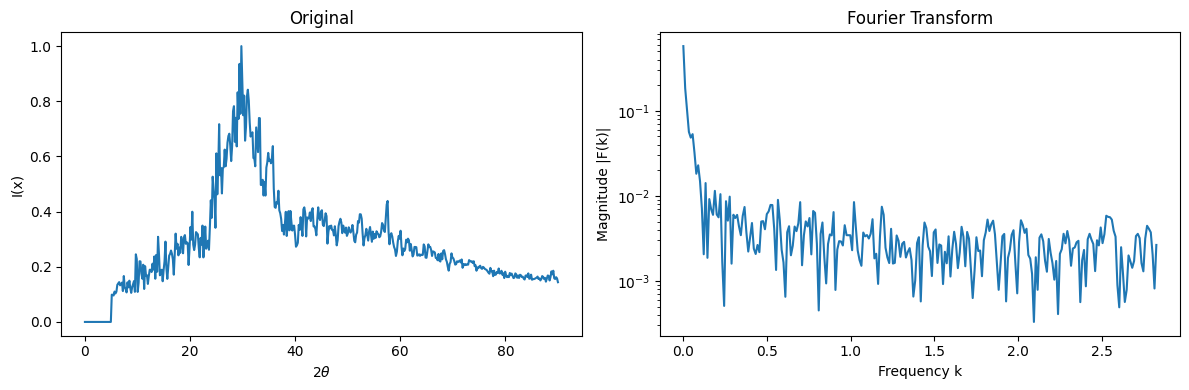

---> Fourier transform of summed CNRS patterns

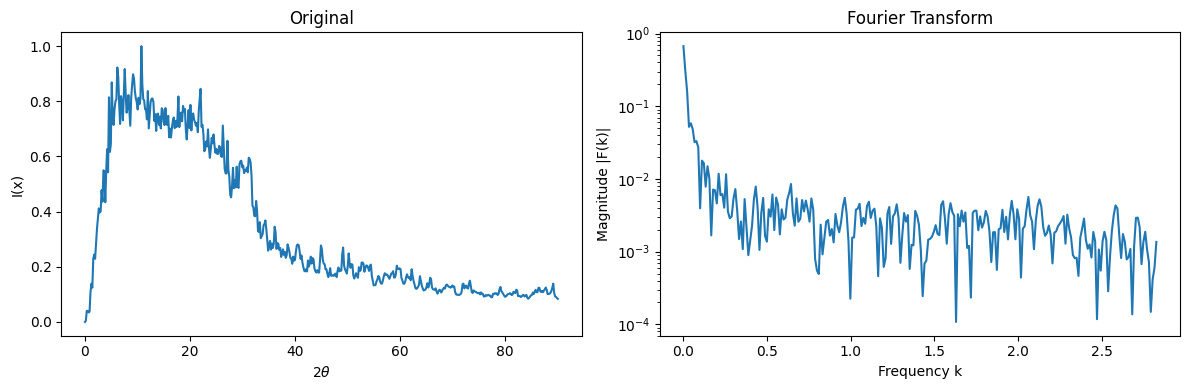

---> Fourier transform of summed IKFT patterns

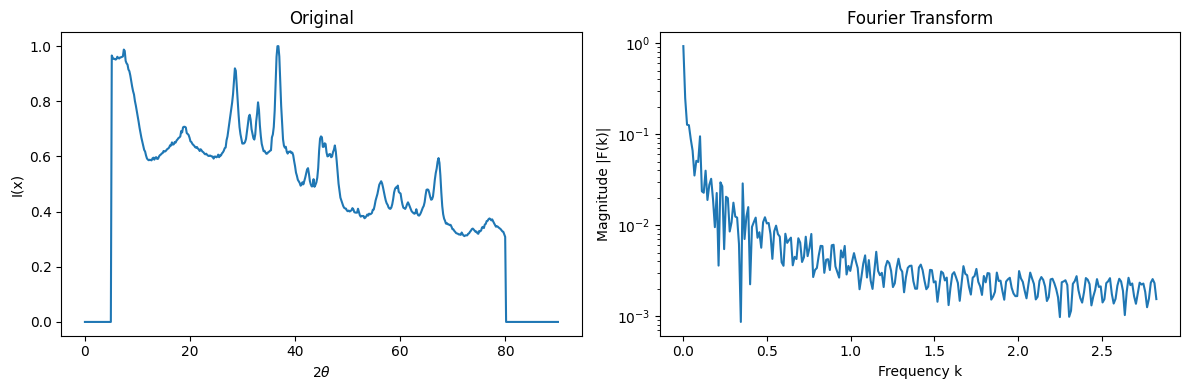

In [30]:
analyser.plot_opxrd_fourier(combine_plots=True)
analyser.plot_opxrd_fourier(combine_plots=False)

---> Combined pattern plot for databaes ['a:EMPA', 'b:LBNL-A', 'c:LBNL-B', 'd:LBNL-C', 'e:USC', 'f:INT', 'g:HKUST-A', 'h:HKUST-B', 'i:CNRS', 'j:IKFT'] | No. patterns = 10

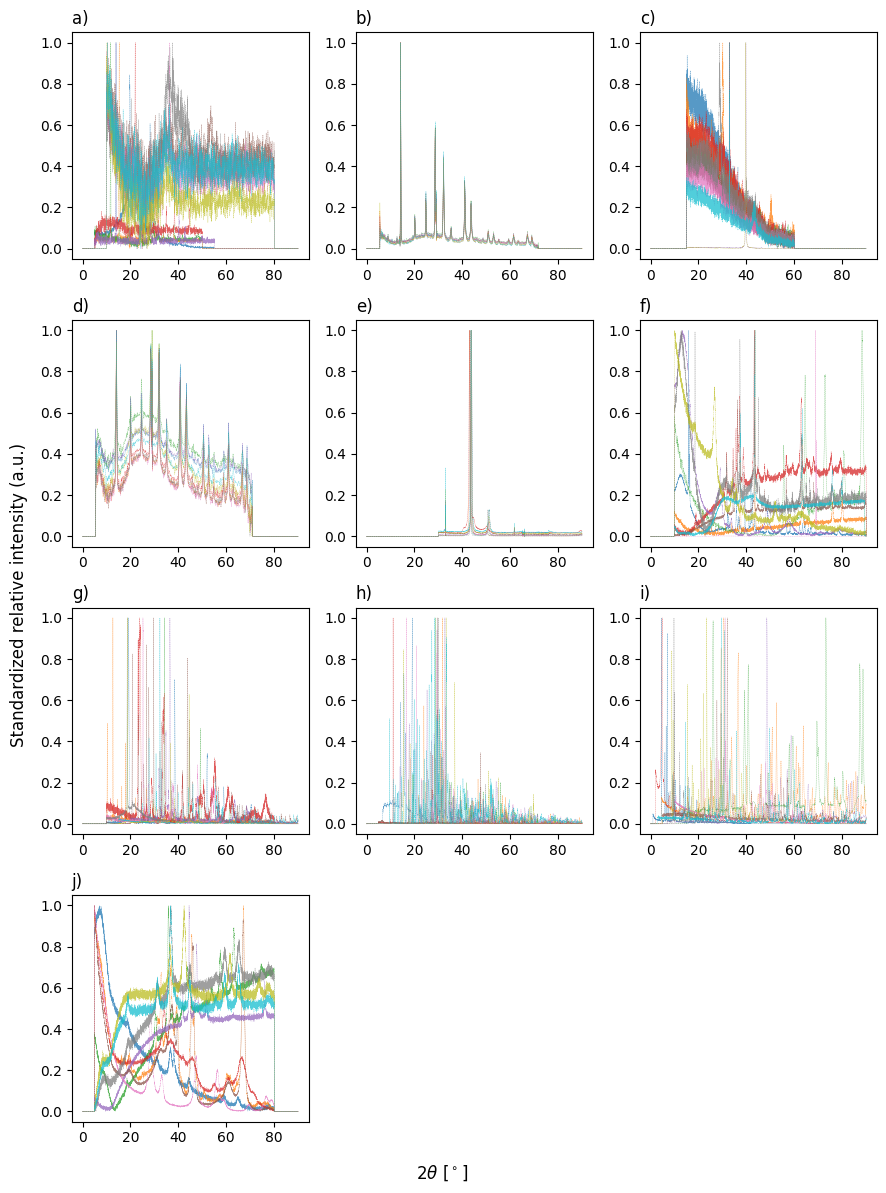

In [31]:
analyser.plot_in_single(limit_patterns=10)

---> Combined pattern plot for databaes ['a:EMPA', 'b:LBNL-A', 'c:LBNL-B', 'd:LBNL-C', 'e:USC', 'f:INT', 'g:HKUST-A', 'h:HKUST-B', 'i:CNRS', 'j:IKFT'] | No. patterns = 50

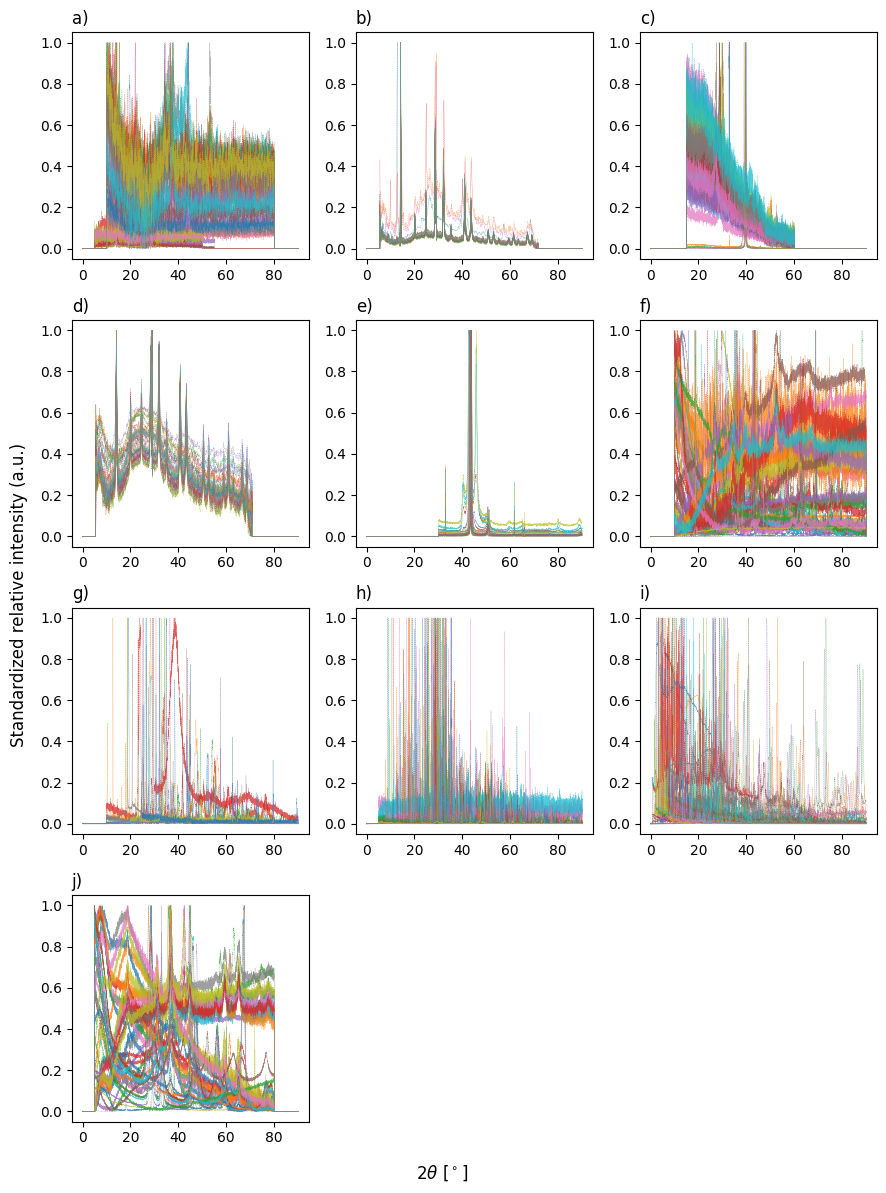

In [32]:
analyser.plot_in_single(limit_patterns=50)

---> Combined pattern plot for databaes ['a:EMPA', 'b:LBNL-A', 'c:LBNL-B', 'd:LBNL-C', 'e:USC', 'f:INT', 'g:HKUST-A', 'h:HKUST-B', 'i:CNRS', 'j:IKFT'] | No. patterns = 100

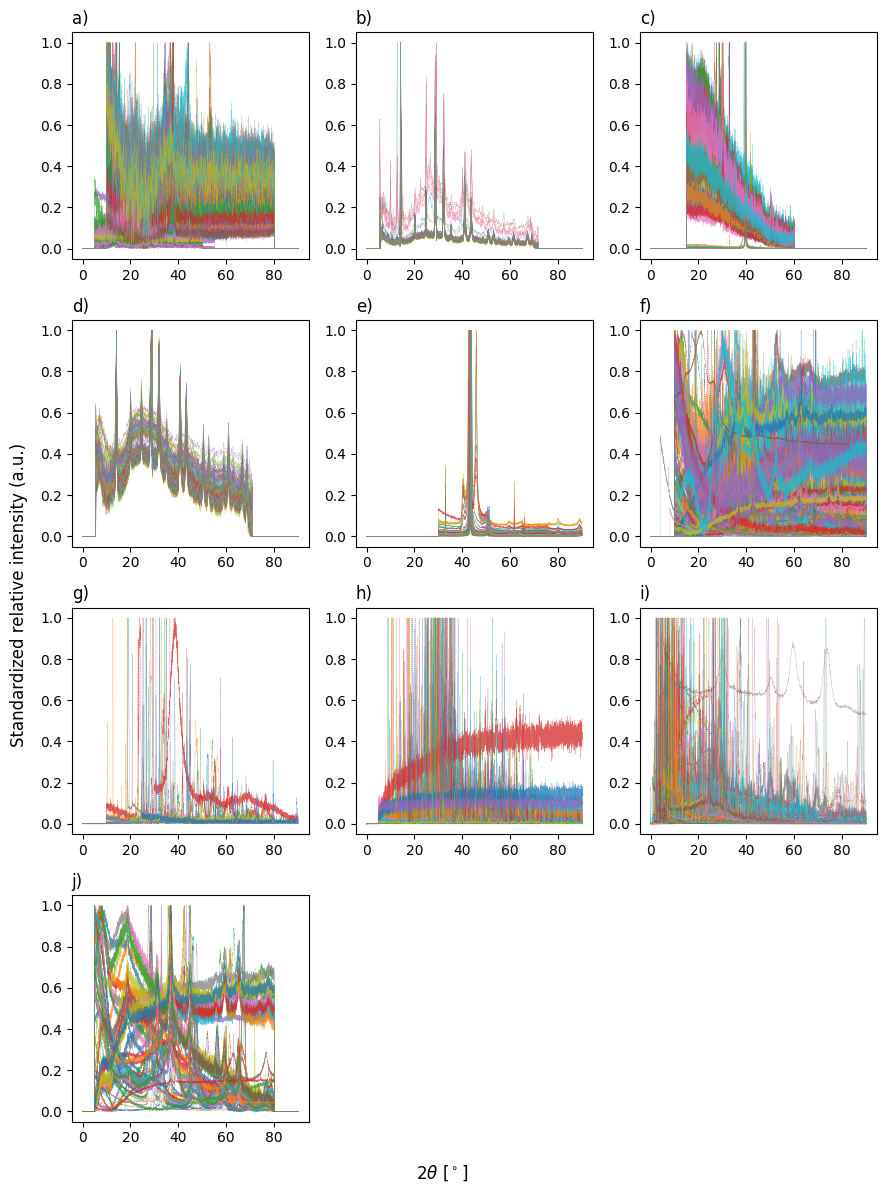

In [33]:
analyser.plot_in_single(limit_patterns=100)

In [ ]:
analyser.plot_in_single(limit_patterns=1000)

---> Combined pattern plot for databaes ['a:EMPA', 'b:LBNL-A', 'c:LBNL-B', 'd:LBNL-C', 'e:USC', 'f:INT', 'g:HKUST-A', 'h:HKUST-B', 'i:CNRS', 'j:IKFT'] | No. patterns = 1000

In [ ]:
analyser.plot_effective_components()
analyser.plot_effective_components(use_fractions=False)

In [ ]:
analyser.plot_histogram()

In [ ]:
analyser.show_label_fractions()
analyser.print_total_counts()